In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model

from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

from numpy.random import seed
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("ner_datasetreference.csv", encoding = 'unicode_escape') 
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [3]:
df = df.fillna(method='ffill')
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


Seperate tokens and tags

In [4]:
Sentences  = df.groupby('Sentence #')['Word'].apply(list)
Tags  = df.groupby('Sentence #')['Tag'].apply(list)

Explore the length of all the sentences in the data. 

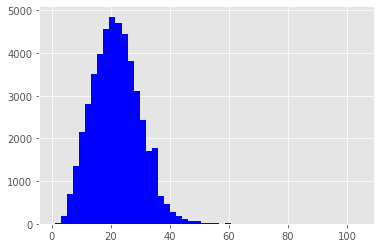

In [5]:
length_sentence = []
length_sentence = list([len(sentence) for sentence in Sentences])

plt.style.use("ggplot")
plt.hist(length_sentence, bins=50, color='blue')
plt.show()

Only few sentences are composed of more than 40 token. 
Traning the model while keeping sentences with a big number of tokens is gonna be memory consuming and the model will take too much time to get trained. So we are gonna keep only sentences with less 40 token. 

In [6]:
selected_sentences = []
selected_tags = []
for i in range(len(Sentences)) :
  if len(Sentences[i]) <= 40 :
    selected_sentences.append(Sentences[i])
    selected_tags.append(Tags[i])

Extract the list of words and tags.

In [ ]:
words = []
for sentence in selected_sentences :
  for word in sentence : 
    words.append(word)
words = list(set(words))
words.append("pad_word")
print(words)

tags=[]
for tag in selected_tags :
  for sub_tag in tag : 
    tags.append(sub_tag)
tags = list(set(tags))
tags.append("XX")
print(tags)

Associate every word to a number

In [8]:
word_to_num = {w: i for i, w in enumerate(words)}
tag_to_num = {w: i for i, w in enumerate(tags)}

Build sentences and their tags from numbers

In [9]:
sentences_to_num = [[word_to_num[y] for y in x] for x in selected_sentences]
tags_to_num = [[tag_to_num[y] for y in x] for x in selected_tags]

In [10]:
print(sentences_to_num[0])
print(tags_to_num[0])

[198, 5628, 13688, 29219, 23283, 23430, 11899, 19420, 9386, 21922, 32709, 33844, 17357, 2930, 4545, 21922, 21736, 5628, 8588, 12976, 27075, 18265, 9558, 26515]
[10, 10, 10, 10, 10, 10, 1, 10, 10, 10, 10, 10, 1, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10]


The longest sentence contains 40 word.

In [11]:
max_len_sentence = max([len(x) for x in selected_sentences])
max_len_sentence

38

The model has to take as input an array with 'max_len_sentence' elements. 
Therefore, we have to add missing values to some sentences in order to reach the maximum length using padding. 
The missing values will be filled by the value of 'XX' 

In [12]:
pad_sentences = pad_sequences(sentences_to_num, maxlen=max_len_sentence, padding='post', value= word_to_num["pad_word"])
pad_tags = pad_sequences(tags_to_num, maxlen=max_len_sentence, padding='post', value= tag_to_num["XX"])

In [13]:
print(pad_sentences[0])
print(pad_tags[0])

[  198  5628 13688 29219 23283 23430 11899 19420  9386 21922 32709 33844
 17357  2930  4545 21922 21736  5628  8588 12976 27075 18265  9558 26515
 34068 34068 34068 34068 34068 34068 34068 34068 34068 34068 34068 34068
 34068 34068]
[10 10 10 10 10 10  1 10 10 10 10 10  1 10 10 10 10 10  9 10 10 10 10 10
 17 17 17 17 17 17 17 17 17 17 17 17 17 17]


Convert pad_tags to np array that represents the class of the tags using 0 and 1

In [14]:
pad_tags = [to_categorical(i, num_classes=len(tag_to_num)) for i in pad_tags]

In [15]:
print(pad_tags[0])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

Split the data to get train and test data

In [16]:
train_pad_sentences = pad_sentences[0:int(len(pad_sentences)*0.9)]
test_pad_sentences = pad_sentences[int(len(pad_sentences)*0.9):]

In [17]:
train_pad_tags = pad_tags[0:int(len(pad_sentences)*0.9)]
test_pad_tags = pad_tags[int(len(pad_sentences)*0.9):]

In [18]:
input = Input(shape=(max_len_sentence,))
model = Embedding(input_dim=len(words), output_dim=max_len_sentence, input_length=max_len_sentence)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=50, return_sequences=True, recurrent_dropout=0.1, dropout=0.2))(model) 
output = TimeDistributed(Dense(len(tags), activation="softmax"))(model) 
model = Model(input, output)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [19]:
history = model.fit(train_pad_sentences, np.array(train_pad_tags), batch_size=32, epochs=10, validation_split=0.1, verbose=1)

Epoch 1/10
1183/1183 [==============================] - 76s 59ms/step - loss: 0.2808 - accuracy: 0.9350 - val_loss: 0.0953 - val_accuracy: 0.9739
Epoch 2/10
1183/1183 [==============================] - 81s 68ms/step - loss: 0.0708 - accuracy: 0.9797 - val_loss: 0.0703 - val_accuracy: 0.9794
Epoch 3/10
1183/1183 [==============================] - 79s 67ms/step - loss: 0.0508 - accuracy: 0.9848 - val_loss: 0.0668 - val_accuracy: 0.9799
Epoch 4/10
1183/1183 [==============================] - 83s 70ms/step - loss: 0.0423 - accuracy: 0.9868 - val_loss: 0.0675 - val_accuracy: 0.9804
Epoch 5/10
1183/1183 [==============================] - 78s 66ms/step - loss: 0.0371 - accuracy: 0.9882 - val_loss: 0.0684 - val_accuracy: 0.9807
Epoch 6/10
1183/1183 [==============================] - 88s 75ms/step - loss: 0.0334 - accuracy: 0.9892 - val_loss: 0.0700 - val_accuracy: 0.9803
Epoch 7/10
1183/1183 [==============================] - 83s 70ms/step - loss: 0.0305 - accuracy: 0.9900 - val_loss: 0.0718 -

In [20]:
test_prediction = model.predict(np.array(test_pad_sentences), verbose=1)

146/146 [==============================] - 2s 8ms/step


In [21]:
num_to_tag = {i: w for w, i in tag_to_num.items()}

def prediction_to_tag(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(num_to_tag[p_i])
        out.append(out_i)
    return out

pred_labels = prediction_to_tag(test_prediction)

In [25]:
def test_to_tag(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(num_to_tag[p_i])
        out.append(out_i)
    return out
    
test_tags = test_to_tag(test_pad_tags)

In [26]:
classification_report(test_tags, pred_labels)

c:\users\lenovo\desktop\lifebit\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: XX seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


              precision    recall  f1-score   support

           X       1.00      1.00      1.00      4637
         art       0.22      0.05      0.08        39
         eve       0.39      0.32      0.35        37
         geo       0.81      0.86      0.84      3591
         gpe       0.98      0.91      0.94      1600
         nat       0.50      0.40      0.44        15
         org       0.62      0.62      0.62      1808
         per       0.72      0.68      0.70      1568
         tim       0.86      0.83      0.85      1902

   micro avg       0.86      0.85      0.86     15197
   macro avg       0.68      0.63      0.65     15197
weighted avg       0.86      0.85      0.86     15197

